## <u>*Regression Modelling for Severity as a Target Feature*</u>

In [147]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

In [148]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


---

In [149]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


*Date preprocessing*

In [150]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,9,0,0,0,0
1,1.46,0.221766,0.0,3,0,0,0,0
2,1.54,0.238193,0.0,9,0,0,0,0
3,1.57,0.522930,0.0,9,0,0,0,0
4,1.41,0.219028,0.0,3,0,0,0,0


In [151]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
21,2.560,0.810404,11653.230000,4,0,0,0,0
40,1.399,0.862423,1259.189999,3,0,0,0,0
50,3.130,0.407940,850.830000,10,0,0,0,0
63,1.399,0.358658,367.730000,3,0,0,0,0
65,1.470,0.353183,200.000000,3,0,0,0,0


*Define x and y*

In [152]:
x=df.drop("claimcst0",axis=1)
y=df["claimcst0"]

In [153]:
sc=StandardScaler()
for col in x:
        x[[col]]=StandardScaler().fit_transform(x[[col]])

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.25)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3468, 7) and Y = (3468,) : 
Test data shape of X = (1156, 7) and Y = (1156,) : 


*Create cross validation evaluation_fucntion*

In [158]:
def evaluation_preds(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    metrics_dict={
       "RMSE": round(RMSE,3)
    }
   
    return metrics_dict

---

## *Hyperparamers tunning*

* *Defining models and its parameters*

In [156]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor()
        
}

search_spaces ={        
        "XGBRFRegressor":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [None,2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1),
            "num_parallel_tree": hp.choice("num_parallel_tree", [100,110])
            },
                    
        "GradientBoostingRegressor":{
            #"loss": hp.choice("loss",['squared_error', 'huber', 'absolute_error', 'quantile']),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            #"max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            #"criterion": hp.choice("criterion",["squared_error", "friedman_mse"]) 
            },
        "RandomForestRegressor":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            #"bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            #"max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            #"criterion": hp.choice("criterion",["poisson", "squared_error", "friedman_mse","absolute_error"])                    
        },

        "AdaBoostRegressor":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            #"loss": hp.choice("loss",["linear","square","exponential"])
        },
        "DecisionTreeRegressor": {
                    "criterion": hp.choice("criterion",["poisson", "squared_error", "friedman_mse","absolute_error"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

In [159]:
np.random.seed(42)
clf=RandomForestRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
evaluation_preds(y_test,predicted)

{'RMSE': np.float64(3328.702)}

In [160]:

print("===========================================rf_base_evaluation===========================================")
np.random.seed(42)
clf=RandomForestRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
rf_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , rf_base_evaluation)
print("===========")

print("===========================================XGBRF_base_evaluation===========================================")
np.random.seed(42)
clf=XGBRFRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
XGBRF_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , XGBRF_base_evaluation)
print("===========")

print("===========================================ADAboost_base_evaluation===========================================")
np.random.seed(42)
clf=AdaBoostRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
ADAboost_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , ADAboost_base_evaluation)
print("===========")

print("===========================================GradientBoostingClassifier===========================================")
np.random.seed(42)
clf=GradientBoostingRegressor()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)
GBOOST_base_evaluation=evaluation_preds(y_test,predicted)
print("RF_cross_val_evaluation_preds :\n" , GBOOST_base_evaluation)
print("==================================================================")  


===========================================rf_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'RMSE': np.float64(3328.702)}
===========================================XGBRF_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'RMSE': np.float64(3141.203)}
===========================================ADAboost_base_evaluation===========================================
RF_cross_val_evaluation_preds :
 {'RMSE': np.float64(9049.567)}
===========================================GradientBoostingClassifier===========================================
RF_cross_val_evaluation_preds :
 {'RMSE': np.float64(3060.012)}


In [161]:
np.random.seed(42)
basemodels=pd.DataFrame({
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation
})
basemodels

,rf_base_evaluation,ADAboost_base_evaluation,XGBRF_base_evaluation,GBOOST_base_evaluation
RMSE,3328.702,9049.567,3141.203,3060.012


<Axes: >

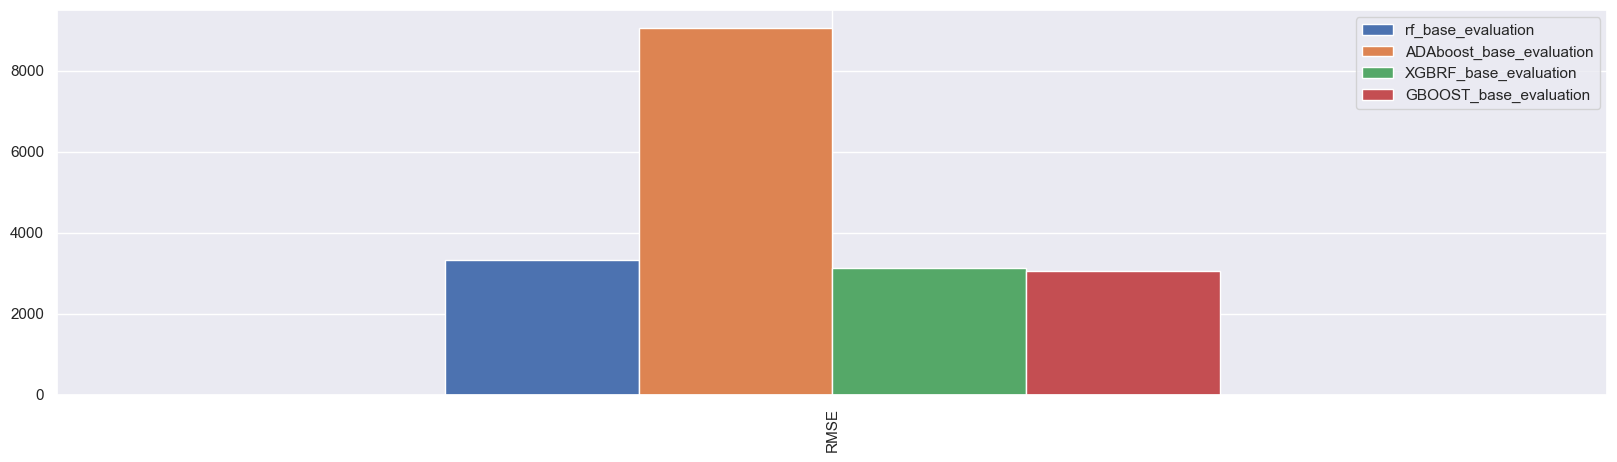

In [162]:
basemodels.plot(kind="bar",figsize=(20,5))

* *AdaBoostRegressor hyperparameter*

In [171]:
space=search_spaces["AdaBoostRegressor"]
def hyperparameter_tuning(space):
    clf = AdaBoostRegressor(**space)
    clf.fit(x_train,y_train)
    RMSE = root_mean_squared_error(y_test,clf.predict(x_test))
    RMSE=round(RMSE,3)

    return {"loss": RMSE, "status": STATUS_OK}

trials = Trials()
best_AdaBoostRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)     

100%|██████████| 10/10 [00:01<00:00,  6.09trial/s, best loss: 4182.266]


* *GradientBoostingRegressor hyperparameter*

In [167]:
space=search_spaces["GradientBoostingRegressor"]
def hyperparameter_tuning(space):
    clf = GradientBoostingRegressor(**space)
    clf.fit(x_train,y_train)
    RMSE = root_mean_squared_error(y_test,clf.predict(x_test))
    RMSE=round(RMSE,3)

    return {"loss": RMSE, "status": STATUS_OK}

trials = Trials()
best_GradientBoostingRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)  

100%|██████████| 10/10 [00:02<00:00,  3.78trial/s, best loss: 3126.811]


* *RandomForestRegressor hyperparameter*

In [177]:
space=search_spaces["RandomForestRegressor"]
def hyperparameter_tuning(space):
    clf = RandomForestRegressor(**space)
    clf.fit(x_train,y_train)
    RMSE = root_mean_squared_error(y_test,clf.predict(x_test))
    RMSE=round(RMSE,3)

    return {"loss": RMSE, "status": STATUS_OK}

trials = Trials()
best_RandomForestRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)      

100%|██████████| 10/10 [00:06<00:00,  1.55trial/s, best loss: 3127.617]


* *XGBRFRegressor hyperparameter*

In [169]:
space=search_spaces["XGBRFRegressor"]
def hyperparameter_tuning(space):
    clf = XGBRFRegressor(**space)
    clf.fit(x_train,y_train)
    RMSE = root_mean_squared_error(y_test,clf.predict(x_test))
    RMSE=round(RMSE,3)

    return {"loss": RMSE, "status": STATUS_OK}

trials = Trials()
best_XGBRFRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)

100%|██████████| 10/10 [00:04<00:00,  2.32trial/s, best loss: 3068.447]


In [178]:
print("===========================================best_AdaBoostClassifier===========================================")
model = AdaBoostRegressor(**best_AdaBoostRegressor)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
ADAboost_evaluation_preds=evaluation_preds(y_test,predicted) 
print("===========")

print("===========GradientBoostingRegressor===========")
model = GradientBoostingRegressor(**best_GradientBoostingRegressor)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
GBOOST_evaluation_preds=evaluation_preds(y_test,predicted)  
print("===========")

print("===========XGBRFRegressor===========")
model = XGBRFRegressor(**best_XGBRFRegressor)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
XGBRF_evaluation_preds=evaluation_preds(y_test,predicted)  
print("===========")

print("===========RandomForestRegressor===========")
model = RandomForestRegressor(**best_RandomForestRegressor)
model.fit(x_train,y_train)
predicted=model.predict(x_test)
print("evaluation_preds :\n" , evaluation_preds(y_test,predicted))
RF_evaluation_preds=evaluation_preds(y_test,predicted)
print("=====================================================================")  


===========================================best_AdaBoostClassifier===========================================
evaluation_preds :
 {'RMSE': np.float64(3045.615)}
===========GradientBoostingRegressor===========
evaluation_preds :
 {'RMSE': np.float64(3128.195)}
===========XGBRFRegressor===========
evaluation_preds :
 {'RMSE': np.float64(3110.705)}
===========RandomForestRegressor===========
evaluation_preds :
 {'RMSE': np.float64(3124.622)}


*Saving all best hyperopt param*

In [179]:
import json
# Serializing json
json_object = json.dumps({
    "best_AdaBoostRegressor" : best_AdaBoostRegressor,
    "best_GradientBoostingRegressor" :best_GradientBoostingRegressor,
    "best_RandomForestRegressor" :best_RandomForestRegressor,
    "best_XGBRFRegressor" :best_XGBRFRegressor}, indent=4,default=str)
 
# Writing to sample.json
with open("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestParams/claims_regression_all_best_params.json", "w") as f:
    f.write(json_object)

*Saving all models evaluations*

In [180]:
import json
# Serializing json
json_object = json.dumps({"ADAboost_evaluation_preds" : ADAboost_evaluation_preds,
    "GBOOST_evaluation_preds" :GBOOST_evaluation_preds,
    "XGBRF_evaluation_preds" :XGBRF_evaluation_preds,
    "RF_evaluation_preds" :RF_evaluation_preds,
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation}, indent=4)
 
# Writing to sample.json
with open("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluations/claims_regression_all_evaluations.json", "w") as f:
    f.write(json_object)

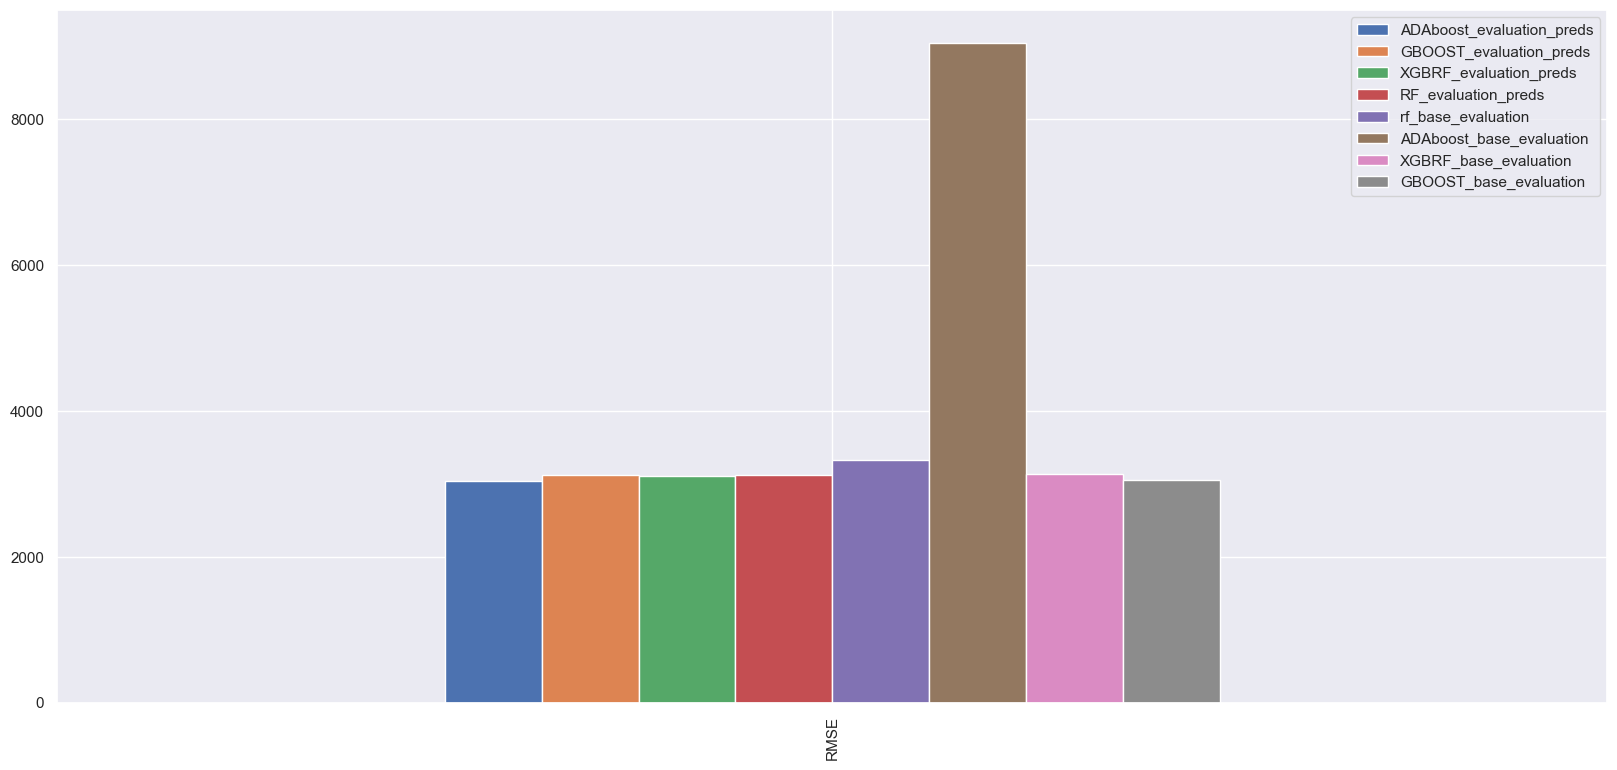

In [181]:
np.random.seed(42)
comparison=pd.DataFrame({
    "ADAboost_evaluation_preds" : ADAboost_evaluation_preds,
    "GBOOST_evaluation_preds" :GBOOST_evaluation_preds,
    "XGBRF_evaluation_preds" :XGBRF_evaluation_preds,
    "RF_evaluation_preds" :RF_evaluation_preds,
    "rf_base_evaluation":rf_base_evaluation,
    "ADAboost_base_evaluation":ADAboost_base_evaluation,
    "XGBRF_base_evaluation":XGBRF_base_evaluation,
    "GBOOST_base_evaluation":GBOOST_base_evaluation
})
comparison.plot(kind="bar",figsize=(20,9))
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/claims_EvaluationsGraph.png',dpi=500); 

In [182]:
comparison

,ADAboost_evaluation_preds,GBOOST_evaluation_preds,XGBRF_evaluation_preds,RF_evaluation_preds,rf_base_evaluation,ADAboost_base_evaluation,XGBRF_base_evaluation,GBOOST_base_evaluation
RMSE,3045.615,3128.195,3110.705,3124.622,3328.702,9049.567,3141.203,3060.012


### *Final Result*

In [185]:
np.random.seed(42)
model = AdaBoostRegressor(**best_AdaBoostRegressor)
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

In [187]:
clf.feature_names=x.columns
importance=pd.concat([pd.DataFrame(clf.feature_names,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.417933
1,exposure,0.322131
2,veh_body,0.039395
3,veh_age,0.041302
4,gender,0.030803
5,area,0.115077
6,agecat,0.033359


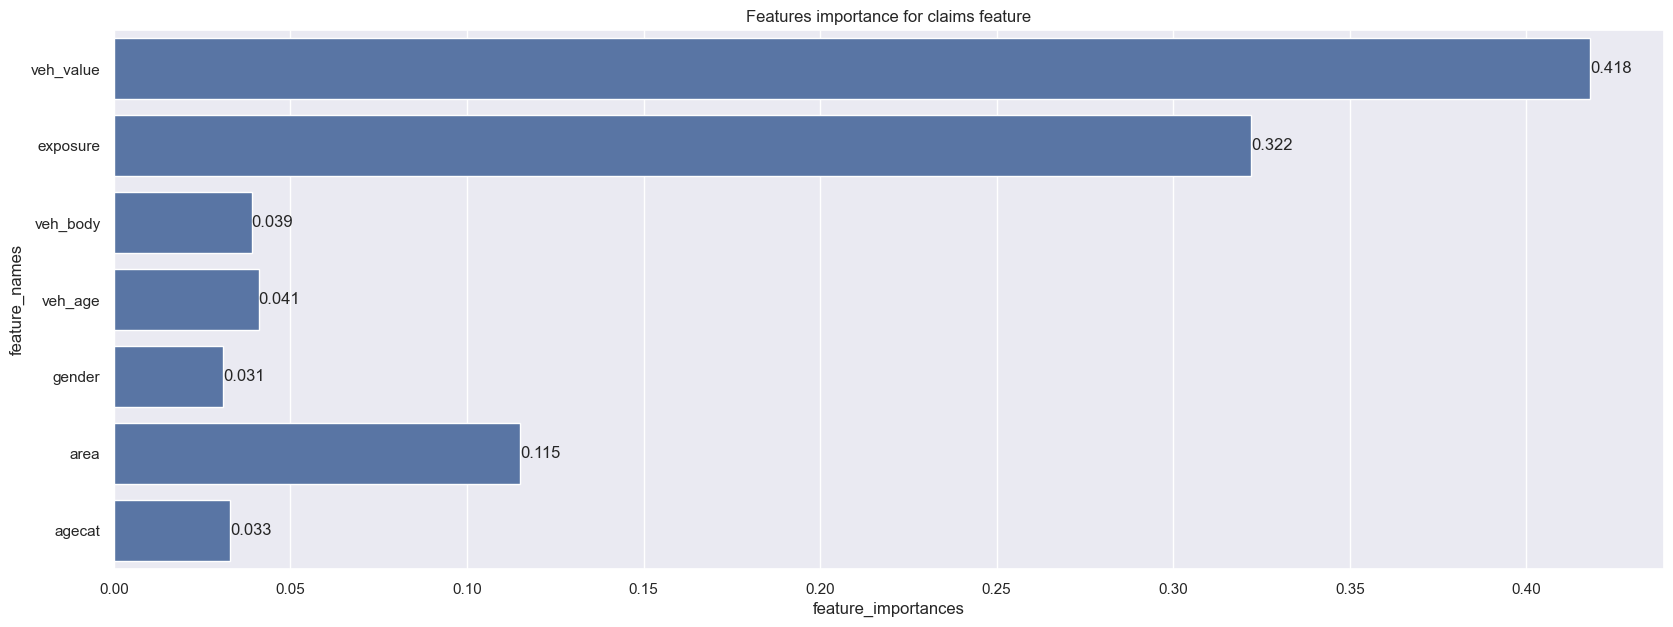

In [188]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for claims feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/claims_featureImportanc.png',dpi=500);

In [189]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/claims_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---